atma cup2講座を参考に作成

In [93]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib_venn import venn2

In [94]:
DATA = '~/art_compe/data/'
OUT_PUT = 'out_put/2/'
os.makedirs(OUT_PUT, exist_ok=True)

In [95]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from time import time

def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = '★' * 20

    return ' '.join([decoration, str(s), decoration])

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' ', verbose=0):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [96]:
import inspect

def param_to_name(params: dict, key_sep='_', key_value_sep='=') -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = '__cachefile__'
    def wrapper(*args, **kwrgs):
        force = kwrgs.pop('force', False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print('run')
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper

In [97]:
@cachable
def read_csv(name):
    if '.csv' not in name:
        name = name + '.csv'
        
    return pd.read_csv(os.path.join(DATA, name))

In [98]:
train_df = read_csv('train')
test_df = read_csv('test')

run
run


特長量作成の改善

In [99]:
class AbstractBaseBlock:
    def fit(self, all_df:pd.DataFrame, input_df:pd.DataFrame, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df:pd.DataFrame):
        return NotImplementedError()

In [100]:
class NumericBlock(AbstractBaseBlock):
    def transform(self, input_df):
        use_columns = [
            'dating_period',
            'dating_year_early',
            'dating_year_late'
        ]
        
        return input_df[use_columns].copy()

In [101]:
class StringLengthBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].str.len()
        return out_df.add_prefix('StringLength_')

In [102]:
class CountEncodingBlock(AbstractBaseBlock):
    def __init__(self, column: str):
        self.column = column
        
    def fit(self, all_df, input_df, y=None):
        vc = all_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].map(self.count_)
        return out_df.add_prefix('CE_')

In [103]:
class OneHotEncoding(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count
        
    def fit(self, all_df, input_df, y=None):
        vc = all_df[self.column].value_counts()
        self.categories = vc[vc > self.min_count].index
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        cat = pd.Categorical(input_df[self.column], categories=self.categories)
        out_df = pd.get_dummies(cat)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'{self.column}=')

In [104]:
feature_blocks = [
    *[OneHotEncoding(c, min_count=20) for c in ['title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[CountEncodingBlock(c) for c in ['art_series_id', 'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],
    *[StringLengthBlock(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
    ]]
]

In [105]:
def run_blocks(all_df, input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()
    
    print(decorate('start run blocks...'))
    
    with Timer(prefix='run test={}'.format(test)):
        for block in blocks:
            with Timer(prefix='\t={}'.format(str(block))):
                if not test:
                    out_i = block.fit(all_df, input_df, y=y)
                else:
                    out_i = block.transform(input_df)
                    
            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)
            
    return out_df

In [106]:
all_df = pd.concat([train_df, test_df], ignore_index=True)
run_blocks(all_df, train_df, blocks=feature_blocks)
run_blocks(all_df, test_df, blocks=feature_blocks, test=True)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	=<__main__.OneHotEncoding object at 0x7f9d90159b50> 0.016[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159c10> 0.015[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159be0> 0.013[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159fa0> 0.014[s]
	=<__main__.OneHotEncoding object at 0x7f9d901592b0> 0.014[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159730> 0.013[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159cd0> 0.006[s]
	=<__main__.OneHotEncoding object at 0x7f9d901591f0> 0.013[s]
	=<__main__.OneHotEncoding object at 0x7f9d901595b0> 0.005[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159a60> 0.009[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159f70> 0.006[s]
	=<__main__.OneHotEncoding object at 0x7f9d901594c0> 0.014[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159370> 0.011[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159190> 0.002[s]
	=<__main__.OneHotEncoding object at 0x7f9d90159880> 0.012[s]
	=<__mai

,title=Portret van een onbekende vrouw@OneHotEncoding,title=Portret van een onbekende man@OneHotEncoding,title=Portret van een onbekende jonge vrouw@OneHotEncoding,title=Portrait of a Man@OneHotEncoding,title=Portrait of a Woman@OneHotEncoding,title=Portret van een vrouw@OneHotEncoding,title=Portret van een man@OneHotEncoding,title=Portret van een onbekende jongen@OneHotEncoding,title=Self-Portrait@OneHotEncoding,description=Deze foto maakt deel uit van een album.@OneHotEncoding,...,CE_dating_sorting_date@CountEncodingBlock,CE_dating_period@CountEncodingBlock,CE_dating_year_early@CountEncodingBlock,CE_dating_year_late@CountEncodingBlock,StringLength_title@StringLengthBlock,StringLength_description@StringLengthBlock,StringLength_long_title@StringLengthBlock,StringLength_principal_maker@StringLengthBlock,StringLength_principal_or_first_maker@StringLengthBlock,StringLength_sub_title@StringLengthBlock
0,0,0,0,0,0,0,0,0,0,0,...,458.0,10135,458.0,765.0,51,NaN,84,18,18,17.0
1,0,0,0,0,0,0,0,0,0,0,...,45.0,6022,45.0,128.0,59,230.0,120,26,26,19.0
2,0,0,0,0,0,0,0,0,0,0,...,32.0,3247,32.0,82.0,36,97.0,59,15,15,17.0
3,0,0,0,0,0,0,0,0,0,0,...,266.0,10135,266.0,380.0,64,309.0,100,21,21,17.0
4,0,0,0,0,0,0,0,0,0,0,...,203.0,6022,203.0,100.0,52,334.0,70,10,10,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12003,0,0,0,0,0,0,0,0,0,0,...,148.0,10135,148.0,148.0,30,NaN,52,14,14,15.0
12004,0,0,0,0,0,0,0,0,0,0,...,298.0,10135,298.0,361.0,126,36.0,180,23,23,17.0
12005,0,0,0,0,0,0,0,0,0,0,...,107.0,10135,107.0,83.0,33,NaN,61,13,13,11.0
12006,0,0,0,0,0,0,0,0,0,0,...,148.0,10135,148.0,148.0,35,NaN,57,14,14,15.0


In [107]:
person_df = read_csv('historical_person')

run


In [108]:
vc = person_df['name'].value_counts()
use_names = vc[vc>30].index
idx = person_df['name'].isin(use_names)
_use_df = person_df[idx].reset_index(drop=True)
pd.crosstab(_use_df['object_id'], _use_df['name'])


name,"Djatiroto, Suikeronderneming",Frederik Hendrik (prins van Oranje),Handels Vereeniging Amsterdam,Jacobus II (koning van Engeland en Schotland),Lodewijk XIV (koning van Frankrijk),"Maria II Stuart (koningin van Engeland, Schotland en Ierland)",Maurits (prins van Oranje),"Musschenbroek, Sam van","Oldenbarnevelt, Johan van","Titzenthaler, Eckart",...,Wehrmacht,Wilhelm II (keizer van Duitsland),Wilhelmina (koningin der Nederlanden),Willem I (prins van Oranje),Willem III (koning der Nederlanden),"Willem III (prins van Oranje en koning van Engeland, Schotland en Ierland)","Wirix, F.J.","Witt, Cornelis de","Witt, Johan de","Álvarez de Toledo, Fernando (3e hertog van Alva)"
object_id,,,,,,,,,,,,,,,,,,,,,
00133be3ff222c9b74b0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0026e030a0209b834b3e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
009d44bd779a8722b00c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
00cd543929cbd97be573,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00d601332278b5dad17e,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff4e08fb9e8887bbe1a3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ff657e8134633815bf1d,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ff7b9c0a4a4cbaa7f7db,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
OBJECT_ID = 'object_id'

In [129]:
def left_join(left, right, on=OBJECT_ID):
    if isinstance(left, pd.DataFrame):
        left = left[on]
    return pd.merge(left, right, on=on, how='left').drop(columns=[on])

In [150]:
class HistoricalPersonBlock(AbstractBaseBlock):
    def __init__(self, min_count=30):
        self.min_count = min_count
        
    def fit(self, all_df, input_df, y=None):
        person_df = read_csv('historical_person')
        vc = person_df['name'].value_counts()
        use_name = vc[vc>self.min_count].index
        idx = person_df['name'].isin(use_name)
        _use_df = person_df[idx].reset_index(drop=True)
        
        self.agg_df_ = pd.crosstab(_use_df['object_id'], _use_df['name'])
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = left_join(input_df, self.agg_df_)
        return out_df.add_prefix(f'HistricalPersonBlock_name')
        
        

In [131]:
block = HistoricalPersonBlock()
block.fit(test_df)

,"HistricalPersonBlock_nameDjatiroto, Suikeronderneming",HistricalPersonBlock_nameFrederik Hendrik (prins van Oranje),HistricalPersonBlock_nameHandels Vereeniging Amsterdam,HistricalPersonBlock_nameJacobus II (koning van Engeland en Schotland),HistricalPersonBlock_nameLodewijk XIV (koning van Frankrijk),"HistricalPersonBlock_nameMaria II Stuart (koningin van Engeland, Schotland en Ierland)",HistricalPersonBlock_nameMaurits (prins van Oranje),"HistricalPersonBlock_nameMusschenbroek, Sam van","HistricalPersonBlock_nameOldenbarnevelt, Johan van","HistricalPersonBlock_nameTitzenthaler, Eckart",...,HistricalPersonBlock_nameWehrmacht,HistricalPersonBlock_nameWilhelm II (keizer van Duitsland),HistricalPersonBlock_nameWilhelmina (koningin der Nederlanden),HistricalPersonBlock_nameWillem I (prins van Oranje),HistricalPersonBlock_nameWillem III (koning der Nederlanden),"HistricalPersonBlock_nameWillem III (prins van Oranje en koning van Engeland, Schotland en Ierland)","HistricalPersonBlock_nameWirix, F.J.","HistricalPersonBlock_nameWitt, Cornelis de","HistricalPersonBlock_nameWitt, Johan de","HistricalPersonBlock_nameÁlvarez de Toledo, Fernando (3e hertog van Alva)"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
!pip install texthero

     |████████████████████████████████| 371 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 241 kB 19.6 MB/s eta 0:00:01
     |████████████████████████████████| 13.2 MB 21.5 MB/s eta 0:00:01
     |████████████████████████████████| 24.2 MB 31.0 MB/s eta 0:00:01
     |████████████████████████████████| 12.9 MB 34.9 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 36.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 30.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 28.3 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 39.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 35.2 MB/s eta 0:00:01
     |████████████████████████████████| 458 kB 31.2 MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=10f09c22fdc68c104e9099ab27b043afa931a05ed8e886ff75fa4f5a3fb7e862
  Stored in directory: /home/sato.mizuki/.cache/pip/wheels/c4/a7/48/0a434133f6d56e87

In [133]:
import texthero as hero

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sato.mizuki/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [134]:
raw_text = train_df['description']
clean_text = hero.clean(raw_text, pipeline=[
    hero.preprocessing.fillna,
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_digits,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_diacritics,
    hero.preprocessing.remove_stopwords
])

/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


In [135]:
# これがこうなる
i = 101
print('{} \n-> {}'.format(raw_text.values[i], clean_text.values[i]))

Berglandschap met een waterval tussen rotsen en boomstammen. De rivier stroomt door een dal tussen twee bergen waarop kastelen staan. 
-> berglandschap met een waterval tussen rotsen en boomstammen  de rivier stroomt door een dal tussen twee bergen waarop kastelen staan 


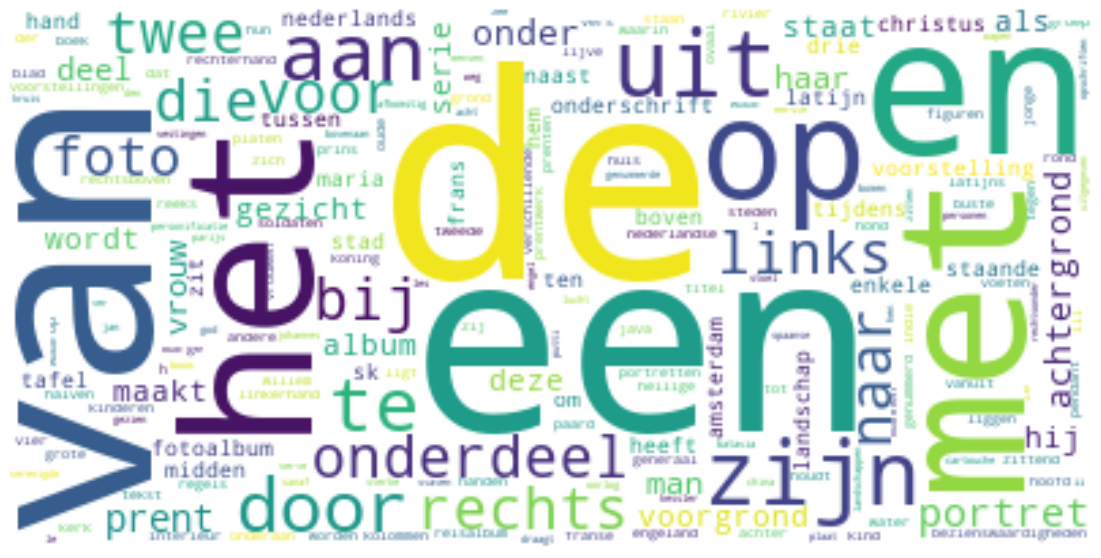

In [136]:
hero.visualization.wordcloud(clean_text, colormap='viridis', background_color='white')

In [137]:
import nltk
nltk.download('stopwords')
os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sato.mizuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['russian',
 'italian',
 'azerbaijani',
 'german',
 'hungarian',
 'greek',
 'kazakh',
 'finnish',
 'arabic',
 'french',
 'turkish',
 'danish',
 'README',
 'portuguese',
 'romanian',
 'nepali',
 'norwegian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'dutch',
 'indonesian',
 'english']

In [138]:
# 英語とオランダ語を stopword として指定
custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

apply_stopword_text = hero.clean(raw_text, pipeline=[
    hero.preprocessing.fillna,
    hero.preprocessing.lowercase,
    hero.preprocessing.remove_digits,
    hero.preprocessing.remove_punctuation,
    hero.preprocessing.remove_diacritics,
    lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
])

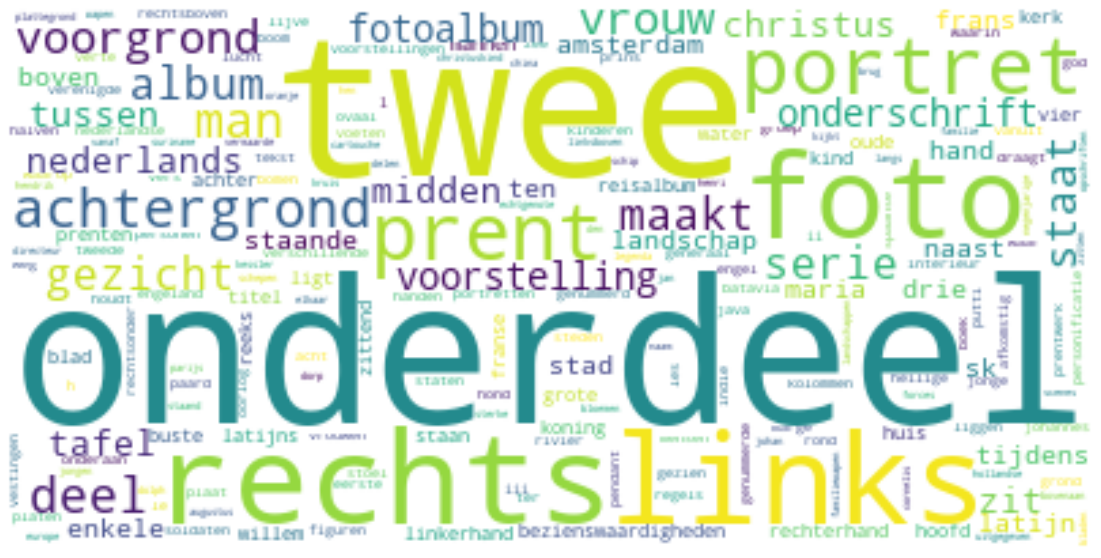

In [139]:
hero.visualization.wordcloud(apply_stopword_text, colormap='viridis', background_color='white')

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [151]:
def text_nomalization(text):
    
    # 英語とオランダ語を stopword として指定
    custom_stopwords = nltk.corpus.stopwords.words('dutch') + nltk.corpus.stopwords.words('english')

    x = hero.clean(text, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        lambda x: hero.preprocessing.remove_stopwords(x, stopwords=custom_stopwords)
    ])

    return x

class TfidfBlock(AbstractBaseBlock):
    def __init__(self, column:str):
        self.column = column
        
    def preprocess(self, input_df):
        x = text_nomalization(input_df[self.column])
        return x
    
    def get_master(self, input_df):
        return input_df
    
    def fit(self, all_df, input_df, y=None):
        master_df = self.get_master(input_df)
        text = self.preprocess(input_df)
        self.pipeline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=10000)),
            ('svd', TruncatedSVD(n_components=50)),
        ])
        
        self.pipeline_.fit(text)
        return self.transform(input_df)
    
    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pipeline_.transform(text)
        
        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'{self.column}_tfidf_')

In [146]:
block = TfidfBlock('title')
block.fit(train_df)

assert block.transform(train_df).equals(block.transform(train_df))
assert block.transform(test_df).equals(block.transform(test_df))

/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/

In [147]:
block.fit(train_df)

/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


,title_tfidf_0,title_tfidf_1,title_tfidf_2,title_tfidf_3,title_tfidf_4,title_tfidf_5,title_tfidf_6,title_tfidf_7,title_tfidf_8,title_tfidf_9,...,title_tfidf_40,title_tfidf_41,title_tfidf_42,title_tfidf_43,title_tfidf_44,title_tfidf_45,title_tfidf_46,title_tfidf_47,title_tfidf_48,title_tfidf_49
0,4.378878e-07,0.000006,6.407723e-06,0.000012,0.000013,0.000031,5.925311e-05,0.000143,0.000005,-0.000134,...,0.000093,0.001212,-0.000640,0.000396,0.000092,-0.000428,-0.000562,-0.000089,-0.000359,0.000309
1,5.628102e-04,-0.000868,6.233235e-04,0.000650,0.001005,-0.000191,2.337782e-03,-0.001201,-0.000013,0.000317,...,0.005352,-0.003338,-0.002490,0.004257,-0.000843,0.002285,-0.002007,-0.001180,-0.002859,0.001277
2,7.148147e-01,-0.397930,2.550702e-02,0.245006,0.189272,-0.134217,3.610130e-01,-0.138402,-0.000924,0.024919,...,0.008575,-0.007307,-0.003523,-0.022802,-0.011155,0.013940,0.009673,0.001990,0.003580,0.007518
3,8.928377e-04,0.001897,1.900539e-03,0.000217,0.004403,0.000159,1.577756e-03,0.000072,0.002794,-0.000534,...,0.011251,-0.039529,0.002428,-0.001239,-0.003594,-0.009252,-0.013522,-0.024741,0.008878,-0.012066
4,1.877122e-04,0.000539,9.737893e-03,-0.000765,0.000723,0.014945,3.354641e-03,-0.003847,-0.000059,0.003678,...,-0.056815,-0.007698,0.096128,0.114405,0.056269,0.035823,-0.068080,0.043448,0.027112,-0.005155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,4.488159e-03,-0.000339,2.471739e-04,-0.008513,0.020927,-0.001831,2.770480e-03,-0.001161,-0.000042,0.000043,...,0.021840,0.013738,0.001229,0.002533,-0.015696,0.001034,0.021060,0.012835,-0.003373,-0.001999
12022,5.199930e-04,0.000152,6.907818e-03,0.000698,0.002651,0.025923,4.094104e-02,0.107014,-0.002076,0.168077,...,-0.026118,0.012223,0.051905,0.019410,0.021985,-0.020084,0.024180,0.015404,-0.012653,-0.050918
12023,6.596012e-04,0.007999,4.199172e-02,0.014357,0.013738,0.043999,8.233655e-02,0.215311,0.000521,-0.168452,...,-0.010631,-0.005698,0.017442,0.012940,0.004312,0.009516,0.004985,-0.006657,-0.006596,-0.001227
12024,2.942199e-04,0.001387,1.933788e-02,0.000367,0.005848,0.045790,1.135411e-01,0.354352,-0.006727,0.546973,...,-0.036236,0.033199,0.129904,0.053681,0.022788,-0.034305,0.006446,0.059922,0.007817,-0.092171


In [152]:
feature_blocks = [
    # one hot encoding
    *[OneHotEncoding(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],

    # count encoding
    *[CountEncodingBlock(c) for c in [
        'art_series_id', 
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
       'copyright_holder', 'more_title', 'acquisition_method',
       'acquisition_date', 'acquisition_credit_line', 'dating_presenting_date',
       'dating_sorting_date', 'dating_period', 'dating_year_early',
       'dating_year_late',]],

    # 文字列長さ
    *[StringLengthBlock(c) for c in [
        'title', 'description', 'long_title',
       'principal_maker', 'principal_or_first_maker', 'sub_title',
    ]],
    # historical person
    HistoricalPersonBlock(),

    # description の tfidf
    TfidfBlock('description')
]


train_feat_df = run_blocks(all_df, train_df, blocks=feature_blocks, test=False)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	=<__main__.OneHotEncoding object at 0x7f9cf504d8e0> 0.021[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504d310> 0.019[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504da00> 0.018[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504d3d0> 0.012[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504d9a0> 0.012[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504db80> 0.013[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504d970> 0.004[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504dcd0> 0.013[s]
	=<__main__.OneHotEncoding object at 0x7f9cf59c5220> 0.005[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422e80> 0.007[s]
	=<__main__.OneHotEncoding object at 0x7f9cf54224f0> 0.005[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422ee0> 0.011[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422c10> 0.009[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422c40> 0.002[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422cd0> 0.009[s]
	=<__mai

/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f9cf5422a60> 4.200[s]
run test=False 4.770[s]


In [153]:
train_feat_df.head()

,title=Portret van een onbekende vrouw@OneHotEncoding,title=Portret van een onbekende man@OneHotEncoding,title=Portret van een onbekende jonge vrouw@OneHotEncoding,title=Portrait of a Man@OneHotEncoding,title=Portrait of a Woman@OneHotEncoding,title=Portret van een vrouw@OneHotEncoding,description=Deze foto maakt deel uit van een album.@OneHotEncoding,description=Onderdeel van Album met foto's van bezienswaardigheden en landschappen in Engeland en van kunst.@OneHotEncoding,"description=Onderdeel van Engels familiealbum met foto's van personen, reizen, cricket en kunstwerken.@OneHotEncoding",description=Deze prent maakt deel uit van een album.@OneHotEncoding,...,description_tfidf_40@TfidfBlock,description_tfidf_41@TfidfBlock,description_tfidf_42@TfidfBlock,description_tfidf_43@TfidfBlock,description_tfidf_44@TfidfBlock,description_tfidf_45@TfidfBlock,description_tfidf_46@TfidfBlock,description_tfidf_47@TfidfBlock,description_tfidf_48@TfidfBlock,description_tfidf_49@TfidfBlock
0,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,0,0,0,0,1,0,0,0,0,...,-0.224458,-0.021954,-0.142001,0.051527,-0.061325,0.072664,-0.124923,0.037232,0.018190,0.026741
3,0,0,0,0,0,0,0,0,0,0,...,0.005783,-0.001958,-0.000852,0.040458,-0.054619,0.043038,-0.029495,-0.008625,-0.010731,-0.033199
4,0,0,0,0,0,0,0,0,0,0,...,0.019313,0.005457,0.014125,-0.014766,0.023427,-0.078734,0.036580,-0.000353,-0.017364,-0.002011


In [154]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from typing import Union, Optional, Iterable

def fit_lgbm(X: np.ndarray, 
             y: np.ndarray, 
             cv: Iterable, 
             y_max: Optional[float] = None,
             params: Optional[dict] = None, 
             verbose: Optional[int] =50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}
    is_silent = verbose is None
    is_cut_y = y_max is not None

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)
    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        # 最大値が決まっている場合, 学習するデータだけ丸めを行なう
        if is_cut_y:
            idx_use = y_train < y_max
            y_train = np.where(idx_use, y_train, y_max)
        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i), verbose=verbose):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        if not is_silent:
            print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    if not is_silent:
        score = mean_squared_error(y, oof_pred) ** .5
        print('Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

y = train_df['likes'].values
y = np.log1p(y)
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

print(decorate('start training'))
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
print(decorate('FINISHED'))

★★★★★★★★★★★★★★★★★★★★ start training ★★★★★★★★★★★★★★★★★★★★
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 1.11329
Early stopping, best iteration is:
[443]	valid_0's rmse: 1.11169
fit fold=0  4.437[s]
Fold 0 RMSLE: 1.1117
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[393]	valid_0's rmse: 1.12994
fit fold=1  4.358[s]
Fold 1 RMSLE: 1.1299
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's rmse: 1.11062
fit fold=2  2.903[s]
Fold 2 RMSLE: 1.1106
[LightGBM] [Warn

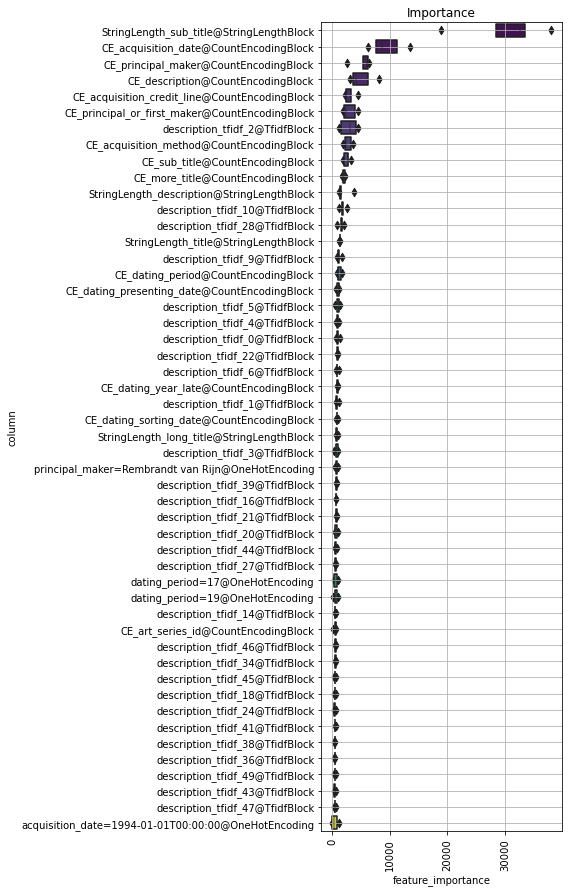

In [155]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

In [156]:
test_feat_df = run_blocks(all_df, input_df=test_df, blocks=feature_blocks, test=True)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	=<__main__.OneHotEncoding object at 0x7f9cf504d8e0> 0.009[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504d310> 0.005[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504da00> 0.003[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504d3d0> 0.009[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504d9a0> 0.008[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504db80> 0.004[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504d970> 0.003[s]
	=<__main__.OneHotEncoding object at 0x7f9cf504dcd0> 0.004[s]
	=<__main__.OneHotEncoding object at 0x7f9cf59c5220> 0.002[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422e80> 0.006[s]
	=<__main__.OneHotEncoding object at 0x7f9cf54224f0> 0.004[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422ee0> 0.009[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422c10> 0.010[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422c40> 0.002[s]
	=<__main__.OneHotEncoding object at 0x7f9cf5422cd0> 0.009[s]
	=<__mai

/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)
/home/sato.mizuki/anaconda3/lib/python3.8/site-packages/texthero/preprocessing.py:131: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(rf"([{string.punctuation}])+", symbol)


	=<__main__.TfidfBlock object at 0x7f9cf5422a60> 1.880[s]
run test=True 2.281[s]


In [159]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUT_PUT, '02__submission.csv'), index=False)